In [2]:
using BioTools, BioSequences
using Plots, StatsPlots
using TreeTools
using StatsBase, Dates, Measures
using Random, Statistics, DelimitedFiles
using LaTeXStrings
include("../plot_functions.jl")
pyplot()

Plots.PyPlotBackend()

In [3]:
base = 20
lfs = base # Legend font size
alfs = base # axis label font size
tfs = base # title font size
atfs = base # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1200,800) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
annfs = 38

38

In [13]:
fp = Flu.FluPop("../alignments/aligned_h3n2_ha_aa.fasta", :aa, Flu.flu_usual_header_fields , 
    flulineage="h3n2", segment="ha",);

Reading ../alignments/aligned_h3n2_ha_aa.fasta...
Read 44976 strains out of 61848. Filtered 16872. Could not read 0


## Activity time

In [14]:
binwidth = Day(60);
binspacing = Day(60);
startdate = Date(2000)
Flu.bin_by_date!(fp, start=startdate, binwidth=binwidth, binspacing = binspacing);

In [15]:
ph_all = Flu.PosEvo(fp);

In [16]:
trajectories1 = Flu.all_trajectories(ph_all, keep_unfinished=true);
trajectories1 = Flu.previous_state_condition(trajectories1, :lost);
trajectories1 = Flu.population_size_condition(trajectories1, 10);
trajectories1 = Flu.min_frequency_condition(trajectories1, 0.2);

In [17]:
activity_dict = Dict()
max_t = 10*365
dt = binspacing.value
for traj in trajectories1
    tmp = Dict()
    i = findfirst(x->x==traj.fixation, [:fixed, :lost])
    for t in [x.value for x in traj.t[2:end-1]] .- traj.t[1].value .- dt
        tmp[t] = get(tmp, t, [0,0,0]) + [1,0,0]
    end
    
    for t in (traj.t[end].value - traj.t[1].value - dt):dt:max_t
        tmp[t] = get(tmp, t, [0,0,0]) + Int64.([0,traj.fixation==:lost,traj.fixation==:fixed])
    end
    
    for (t,v) in tmp
        activity_dict[t] = get(activity_dict, t, [0,0,0]) + tmp[t]
    end
end

In [18]:
active = [x[1]/sum(x) for x in values(activity_dict)]
lost = [x[2]/sum(x) for x in values(activity_dict)]
fixed = [x[3]/sum(x) for x in values(activity_dict)];
n = [Float64(sum(x)) for x in values(activity_dict)]
times = collect(keys(activity_dict))
tmp = sortperm(times)
active = Float64.(active[tmp]); lost = Float64.(lost[tmp]); 
fixed = Float64.(fixed[tmp]); times = Float64.(times[tmp]); n = n[tmp];

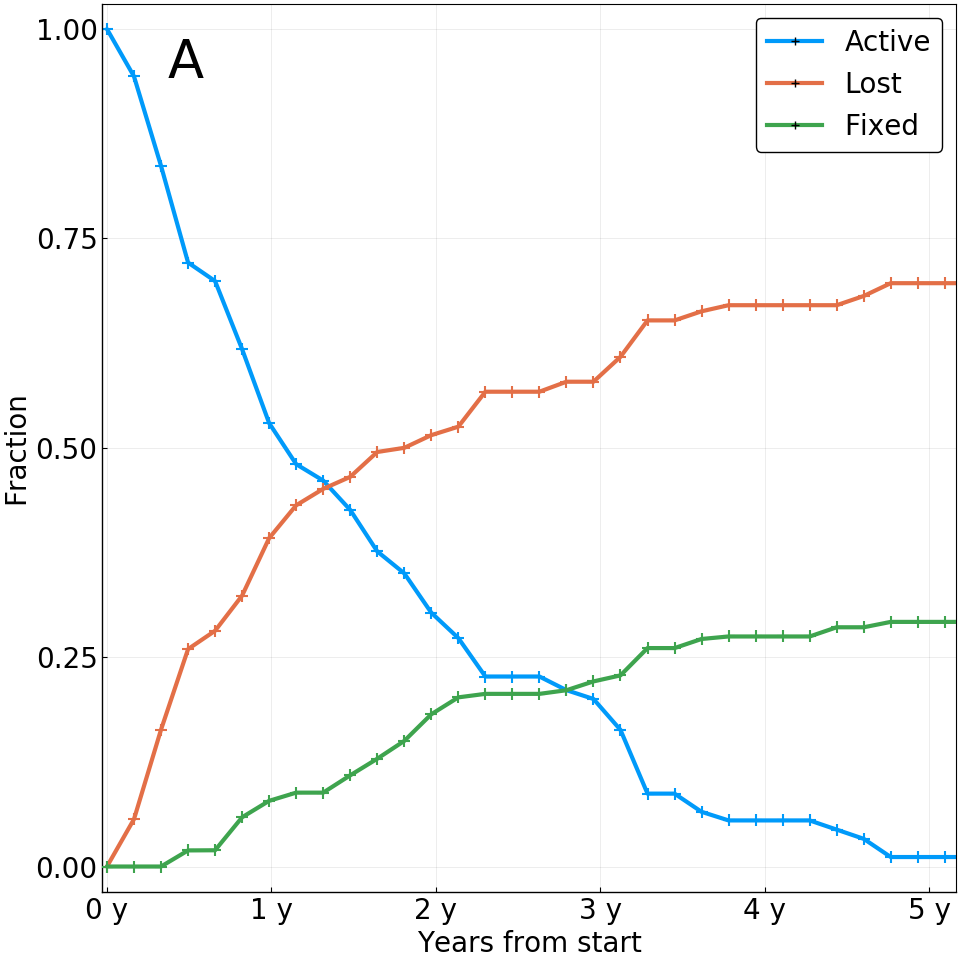

In [19]:
p = plot(times, active .+ 0.0001, label="Active", line = (3), marker=(:+, 8))
plot!(times, lost, label="Lost", line = (3), marker=(:+, 8))
plot!(times, fixed, label="Fixed", line = (3), marker=(:+, 8))
plot!(xlim = (-10,5*365 + 60))
# plot!(xticks=([i*365 for i in 0:5],[i==1 ? "1 year" : "$i years" for i in 0:5]))
plot!(xticks=([i*365 for i in 0:5],["$i y" for i in 0:5]))
plot!(p,size=(1280, 480),frame=:box, title="", xlabel="Years from start", ylabel="Fraction")
plot!(p, tickfontsize=tfs, legendfontsize=lfs, guidefontsize=alfs,titlefontsize=alfs)
annotate!(p, 175, 0.96, text("A", annfs))
p3_sb1 = p
plot!(p, size=(960, 960))

## Pfix v freq

In [20]:
binwidth = Day(30);
binspacing = Day(30);
startdate = Date(2000)
Flu.bin_by_date!(fp, start=startdate, binwidth=binwidth, binspacing = binspacing);

In [21]:
ph_all = Flu.PosEvo(fp);

In [22]:
trajectories_tmp = Flu.all_trajectories(ph_all, keep_unfinished=false)
const trajectories = Flu.previous_state_condition(trajectories_tmp, :lost)
Flu.get_strains!(trajectories, fp)

In [23]:
alphabins_ = 0.125:0.15:0.875
alphabins = [(a, 0.075) for a in alphabins_];

In [25]:
# And adding NA
na_aln = "../alignments/aligned_h3n2_na_aa.fasta"
fp_na = Flu.FluPop(na_aln, :aa, Flu.flu_usual_header_fields, flulineage="h3n2", segment="na");
Flu.bin_by_date!(fp_na, start=startdate, binwidth=binwidth, binspacing=binspacing);
ph_na = Flu.PosEvo(fp_na);

Reading ../alignments/aligned_h3n2_na_aa.fasta...
Read 36300 strains out of 39312. Filtered 3012. Could not read 0


In [28]:
monomorphic_positions_ha = vec(readdlm("../data/monomorphic_positions_ha.txt", Int64));
mpos_ha = vcat([(i-1)*3 .+ [1,2,3] for i in monomorphic_positions_ha]...);
#
fp_ha_nt = Flu.FluPop("../alignments/aligned_h3n2_ha.fasta", :dna, Flu.flu_usual_header_fields,
    flulineage="h3n2", segment="ha");
Flu.bin_by_date!(fp_ha_nt, start=Date(2000), binwidth=Day(30), binspacing=Day(30));
#
ph_ha_nt = Flu.PosEvo(fp_ha_nt);

Reading ../alignments/aligned_h3n2_ha.fasta...
Read 44975 strains out of 61848. Filtered 16873. Could not read 0


In [29]:
monomorphic_positions_na = vec(readdlm("../data/monomorphic_positions_na.txt", Int64));
mpos_na = vcat([(i-1)*3 .+ [1,2,3] for i in monomorphic_positions_na]...);
#
fp_na_nt = Flu.FluPop("../alignments/aligned_h3n2_na.fasta", :dna, Flu.flu_usual_header_fields,
    flulineage="h3n2", segment="ha");
Flu.bin_by_date!(fp_na_nt, start=Date(2000), binwidth=Day(30), binspacing=Day(30));
#
ph_na_nt = Flu.PosEvo(fp_na_nt);

Reading ../alignments/aligned_h3n2_na.fasta...
Read 35985 strains out of 39312. Filtered 3327. Could not read 0


# Pfix v Frequency basic

In [30]:
xna,yna,errna = pfix_v_freq(ph_na, alphabins);
xha, yha, errha = pfix_v_freq(ph_all, alphabins);
# 
xha_s, yha_s, e = pfix_v_freq(ph_ha_nt[mpos_ha], alphabins);
xna_s, yna_s, e = pfix_v_freq(ph_na_nt[mpos_na], alphabins);

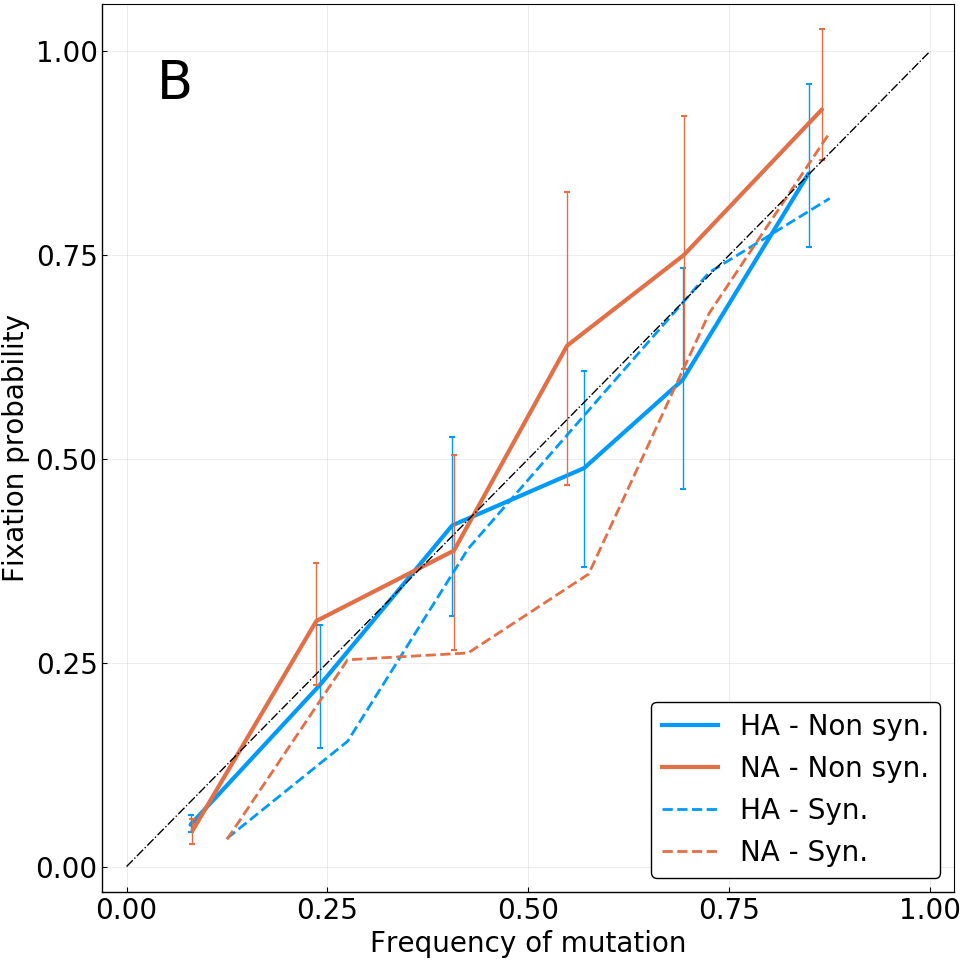

In [35]:
p = plot(size = (1280,960))
plot!(p, xha, yha, yerr=errha, label="HA - Non syn.", line=(3))
plot!(p, xna, yna, yerr=errna, label="NA - Non syn.", line=(3))
plot!(p, xha_s, yha_s, label="HA - Syn.", line=(2, :dash), color=1)
plot!(p, xna_s, yna_s, label="NA - Syn.", line=(2, :dash), color=2)
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability", legend=:bottomright)
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)

p3_sb2 = plot(p, size=(960,960))
annotate!(p3_sb2, 0.06, 0.96, text("B", annfs))

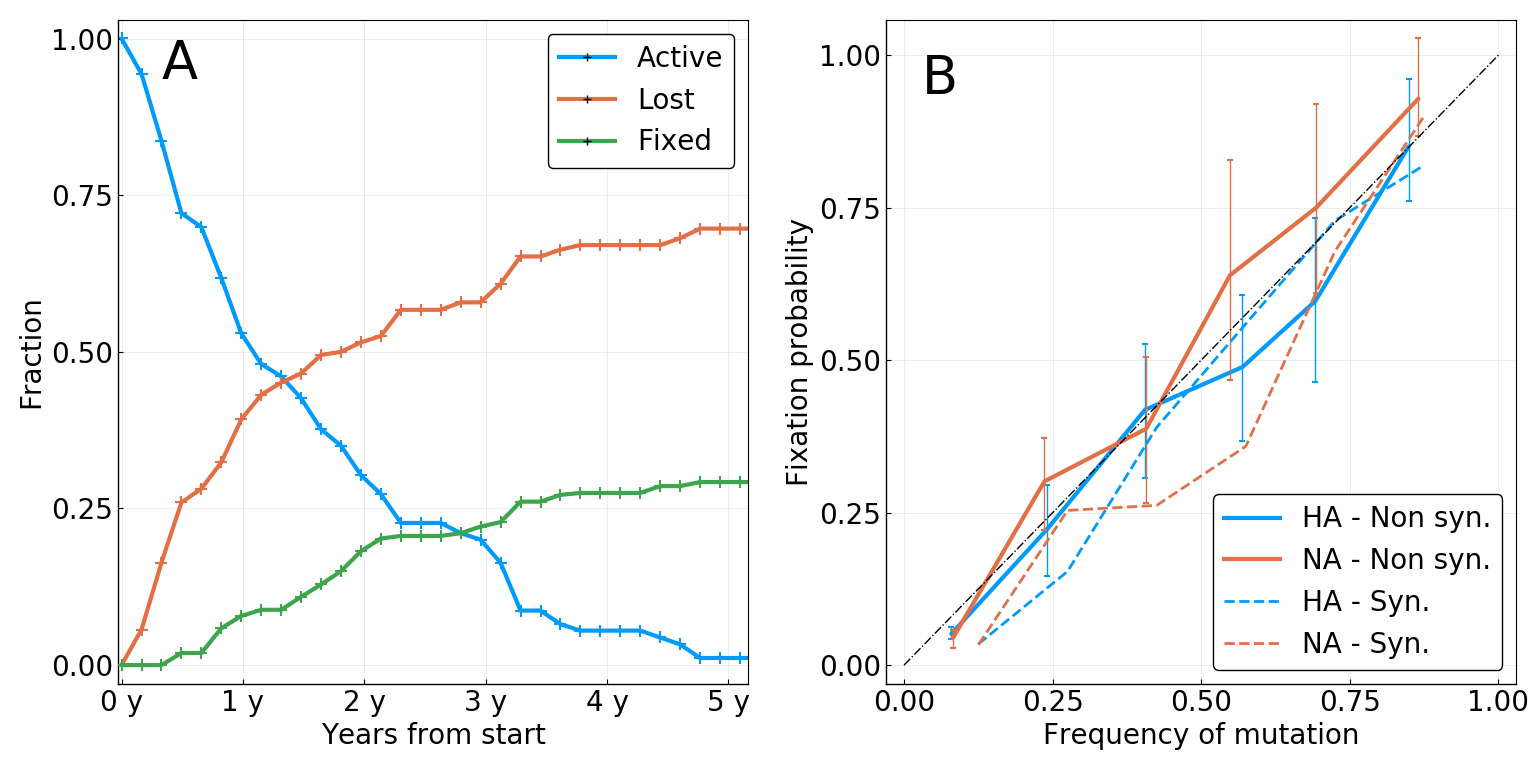

In [36]:
p3 = plot(p3_sb1, p3_sb2, layout=grid(1,2), size=(1280*1.2, 640*1.2), margin=5mm)

## Positive derivative

In [37]:
xha, yha, errha = pfix_v_freq_positivederivative(ph_all, alphabins);
xna, yna, errna = pfix_v_freq_positivederivative(ph_na, alphabins);

In [38]:
p = plot(size = (1280,960))
plot!(p, xha, yha, yerr=errha, label="Influenza HA", line=(3))
plot!(p, xna, yna, yerr=errna, label="Influenza NA", line=(3))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p_sm1_sb3 = p;

# LBI

In [48]:
t = read_tree("../data/tree_raw.nwk", NodeDataType=LBIData);
Flu.get_lbi!(fp, t, verbose=false);
Flu.compute_fitness!(trajectories, fp, :strains, strainfield=:lbi);
dat, dat_low, dat_high = fitness_plot(trajectories, :lbi_fitness);

┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

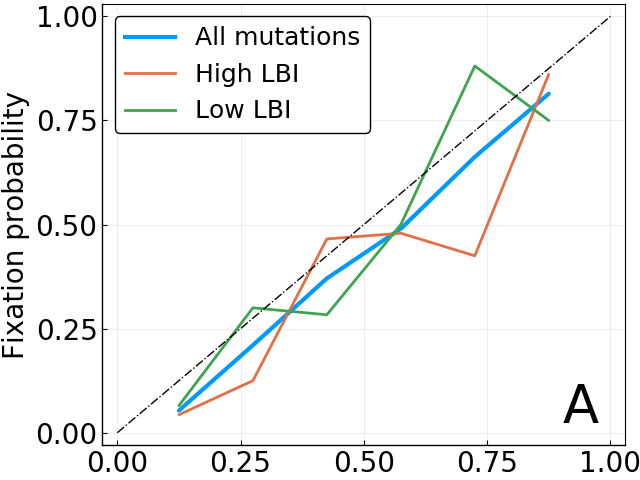

In [55]:
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="High LBI", line=(2), color=2)
plot!(p, dat[:,1], dat_low[:,2], label="Low LBI", line=(2), color=3)
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-2, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb1 = plot(p, size=(640,480))
annotate!(0.94, 0.06, text("A",annfs))

## Epitope positions

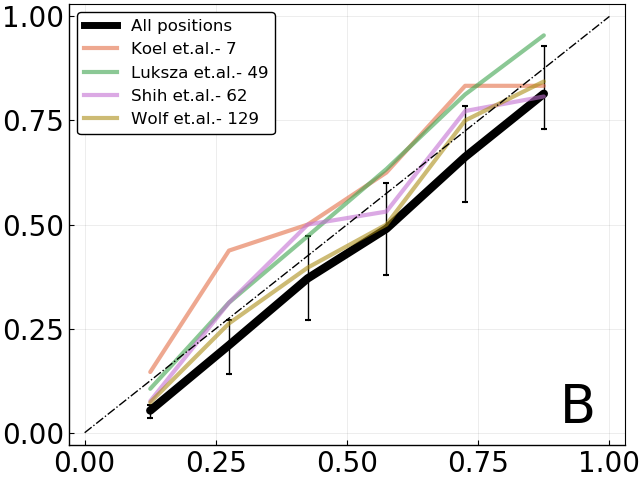

In [57]:
authors = ("Koel", "Luksza", "Shih", "Wolf")
path = "../data/epitopes/ha";
#
xf, yf, (errdown, errup) = pfix_v_freq(ph_all, alphabins)
# 
p = plot(size = (1200,900))
plot!(p, xf, yf, err=(errdown, errup), line=(:black, 6), 
    markercolor=:black, markerstrokecolor=:black, label="All positions")
# Epitopes
for a in authors[1:end]
    pos = vec(readdlm("$(path)/epitope_positions_$(lowercase(a)).txt", Int64))
    x,y = pfix_v_freq(ph_all[pos], alphabins)
    plot!(p, x, y, line=(3), alpha=0.6, label="$a et.al.- $(length(pos))")
end
# #
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))
plot!(p, xlabel="", ylabel="")
plot!(p, legendfontsize=lfs-8, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb2 = plot(p, size=(640,480))
annotate!(0.94, 0.06, text("B",annfs))

## Binary positions

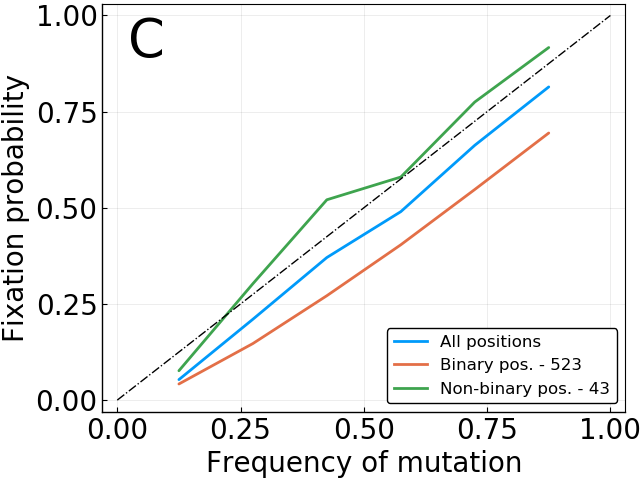

In [65]:
binpos = vec(readdlm("../data/binary_positions_ha.txt", Int64));
nbinpos = findall(x->!in(x,binpos), 1:566) ;
#
xha, yha, errha = pfix_v_freq(ph_all, alphabins);
xha_bin, yha_bin, errha_bin = pfix_v_freq(ph_all[binpos], alphabins);
xha_nbin, yha_nbin, errha_nbin = pfix_v_freq(ph_all[nbinpos], alphabins);
#
p = plot(size = (1280,960))
plot!(p, xha, yha, label="All positions", line=(2))
plot!(p, xha_bin, yha_bin, label="Binary pos. - $(length(binpos))", line=(2))
plot!(p, xha_nbin, yha_nbin, label="Non-binary pos. - $(length(nbinpos))", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))
plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-8, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
#
p4_sb3 = plot(p, size=(640, 480), legend=:bottomright)
annotate!(0.06, 0.93, text("C",annfs))

## Number of times in tree

In [60]:
t = read_tree("../data/tree_refined.nwk");
mutfile = "../data/aa_muts.json"
Flu.read_mutations!(t, mutfile);
for traj in trajectories
    Flu.compute_tree_spread!(traj, t, fp)
end
Flu.compute_fitness!(trajectories, fp, :treespread,)
dat, dat_low, dat_high = fitness_plot(trajectories, :treespread_fitness);

  0.207831 seconds (577.14 k allocations: 82.252 MiB, 16.96% gc time)
NODE_0004401
NODE_0004401
NODE_0004401


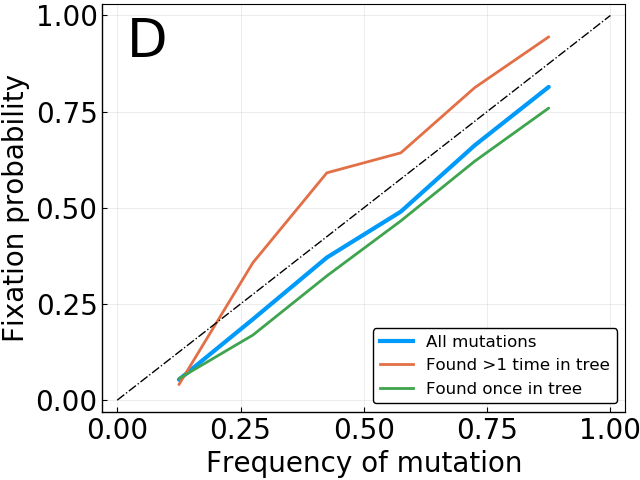

In [62]:
p = plot(size = (1280,960))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="Found >1 time in tree", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Found once in tree", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-8, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p4_sb4 = plot(p, size=(640, 480), legend=:bottomright)
annotate!(0.06, 0.93, text("D",annfs))

## Panel

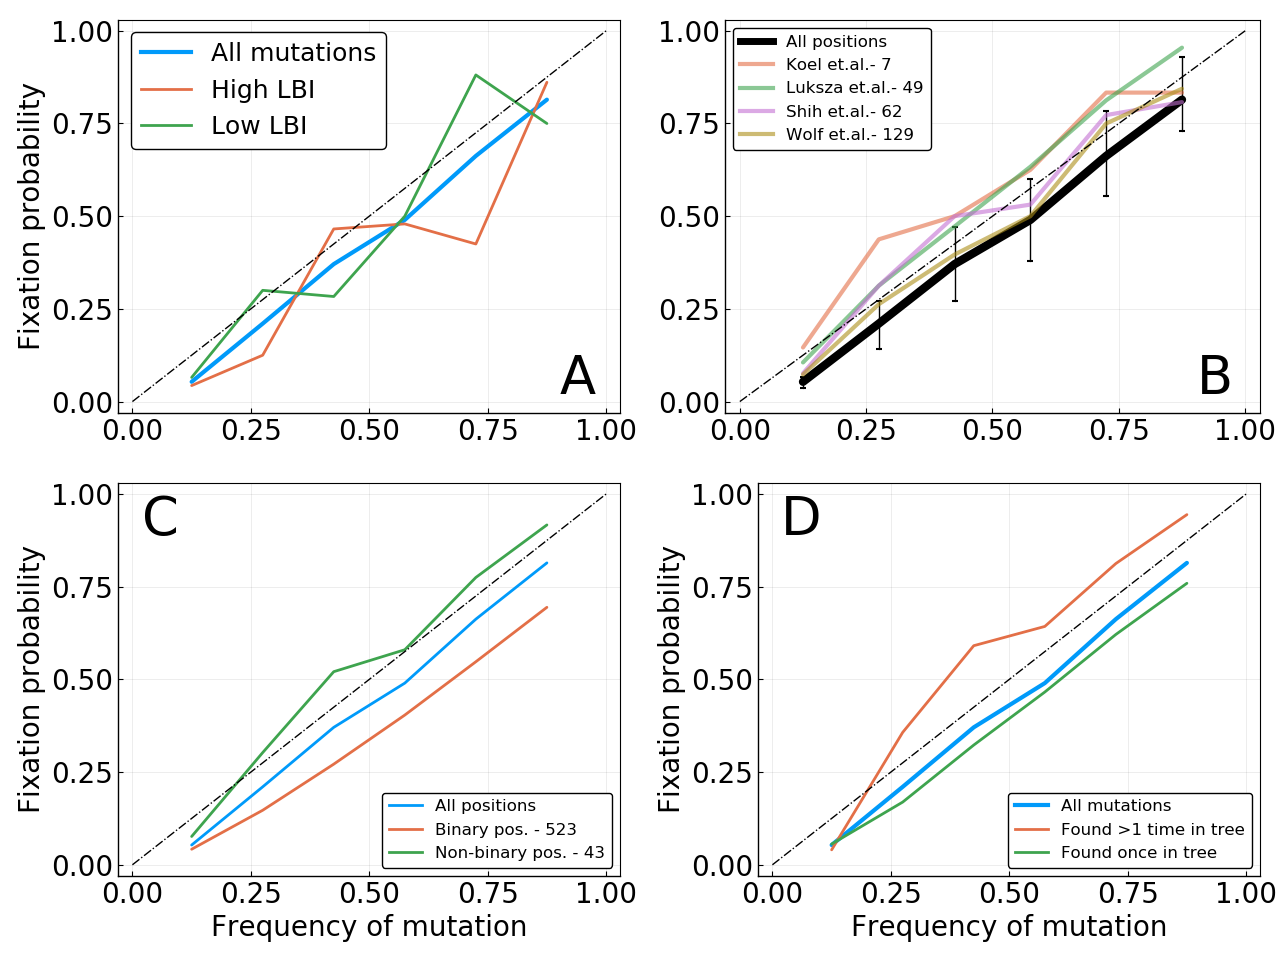

In [66]:
plot(p4_sb1, p4_sb2, p4_sb3, p4_sb4, layout = grid(2,2), size=(1280,960), margin= 5mm)

# SM panel geo

## Geography

In [67]:
Flu.get_regions!(trajectories, fp)
Flu.compute_fitness!(trajectories, fp, :region);
dat, dat_low, dat_high = fitness_plot(trajectories, :region_fitness);

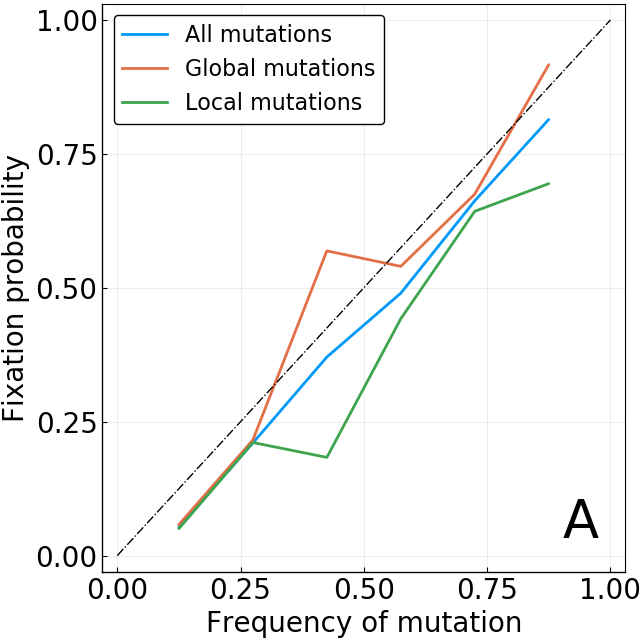

In [68]:
dat, dat_low, dat_high = fitness_plot(trajectories, :region_fitness);
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(2))
plot!(p, dat[:,1], dat_high[:,2], label="Global mutations", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Local mutations", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="Fixation probability")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p_sm2_sb1 = plot(p, size=(640,640))
annotate!(0.94, 0.06, text("A",annfs))

## Date

In [69]:
Flu.compute_fitness!(trajectories, fp, :date)
dat, dat_low, dat_high = fitness_plot(trajectories, :date_fitness);

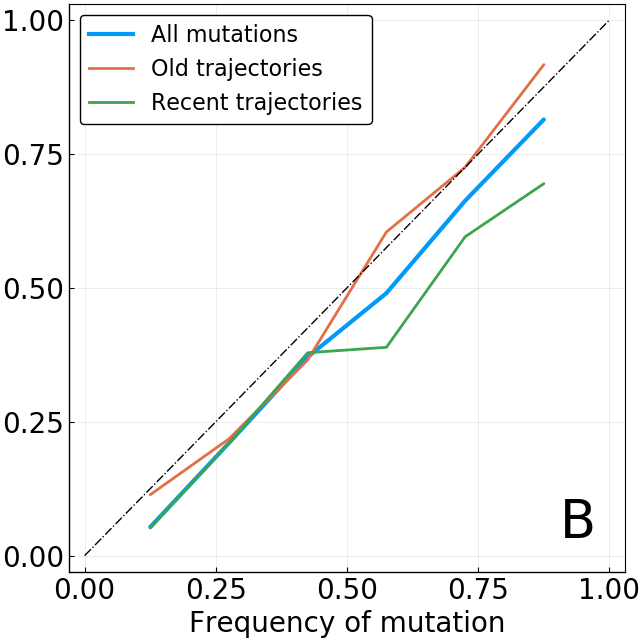

In [70]:
dat, dat_low, dat_high = fitness_plot(trajectories, :date_fitness);
p = plot(size = (1200,900))
plot!(p, dat[:,1], dat[:,2], label="All mutations", line=(3))
plot!(p, dat[:,1], dat_high[:,2], label="Old trajectories", line=(2))
plot!(p, dat[:,1], dat_low[:,2], label="Recent trajectories", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))

plot!(xlabel="Frequency of mutation", ylabel="")
plot!(p, legendfontsize=lfs-4, titlefontsize=tfs, guidefontsize=alfs, tickfontsize=atfs, frame=:box)
p_sm2_sb2 = plot(p, size=(640, 640), legend=:topleft)
annotate!(0.94, 0.06, text("B",annfs))

## Panel

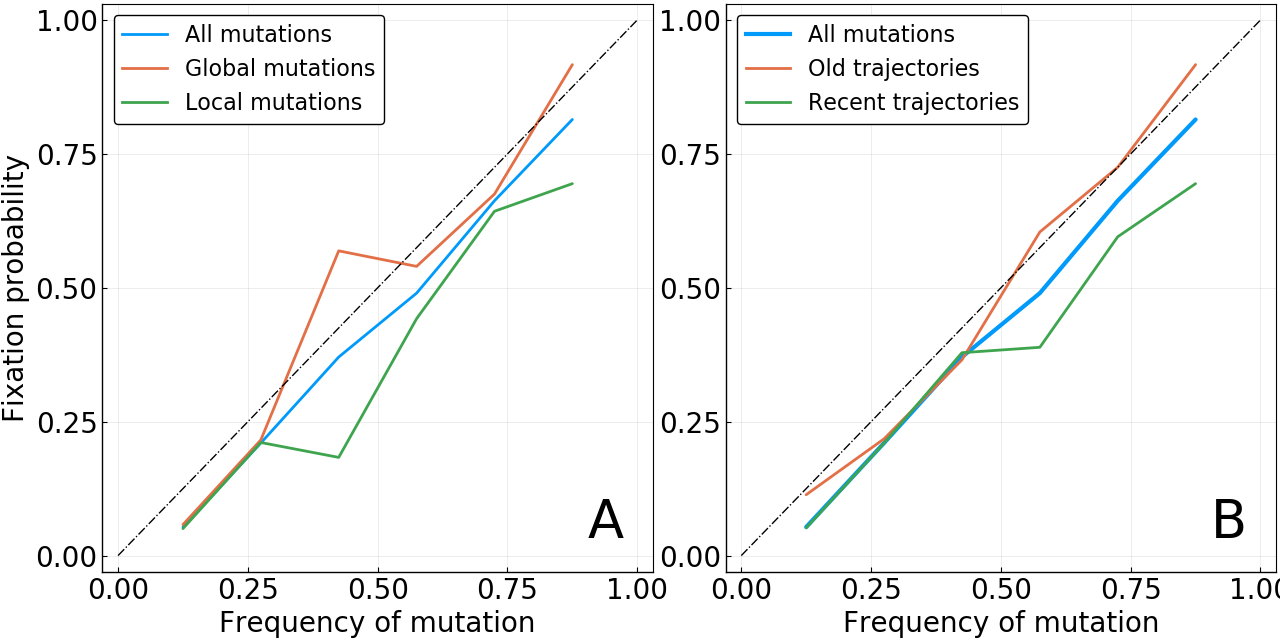

In [71]:
p_sm2 = plot(p_sm2_sb1, p_sm2_sb2, layout=grid(1,2), size=(1280, 640))

## Synonymous mutations

## Binary positions
Positions for which only 2 amino acids are seen at any given time

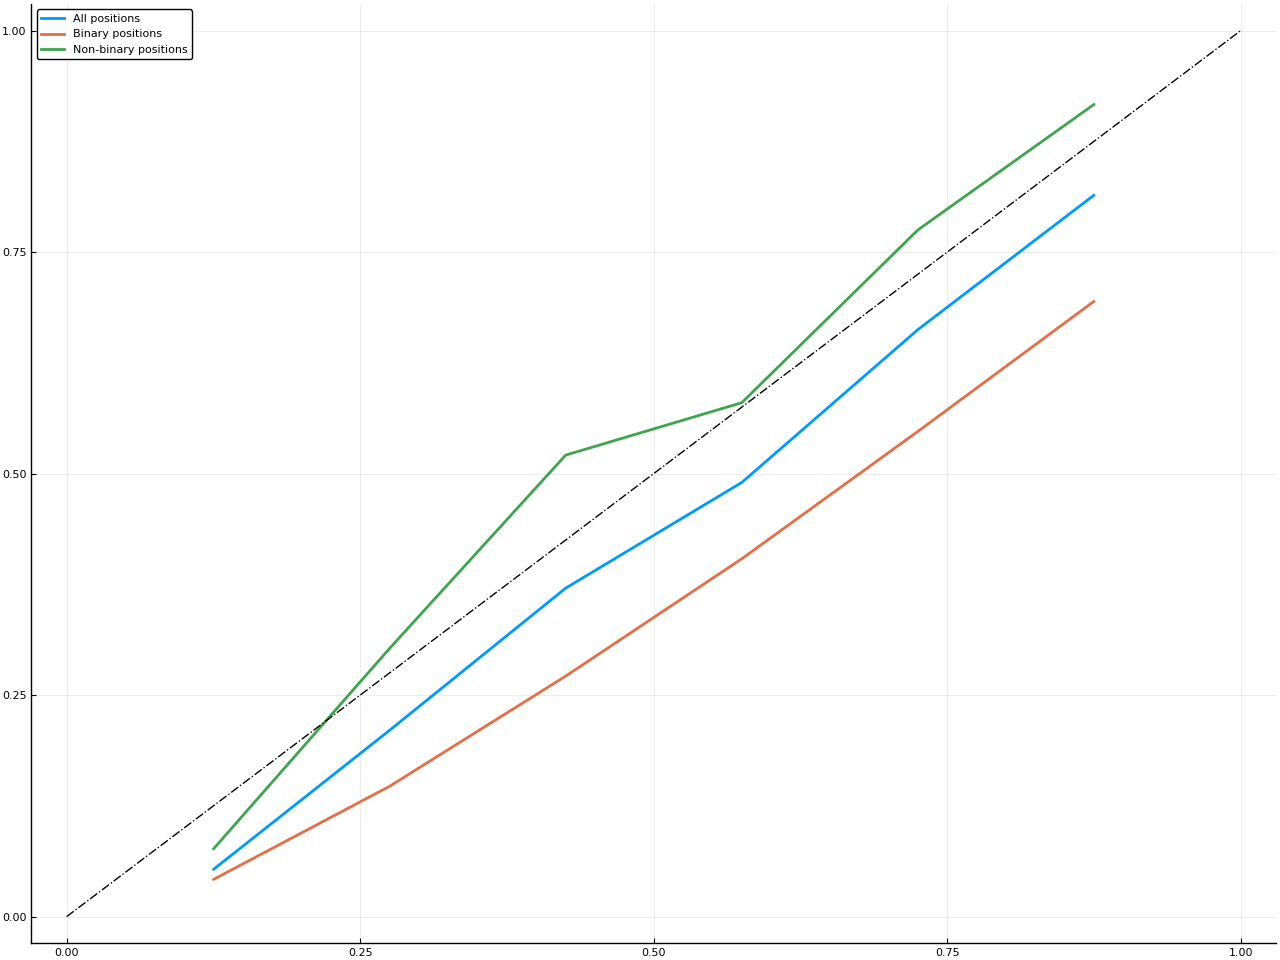

In [73]:
binpos = vec(readdlm("../data/binary_positions_ha.txt", Int64));
nbinpos = findall(x->!in(x,binpos), 1:566) ;
#
xha, yha, errha = pfix_v_freq(ph_all, alphabins);
xha_bin, yha_bin, errha_bin = pfix_v_freq(ph_all[binpos], alphabins);
xha_nbin, yha_nbin, errha_nbin = pfix_v_freq(ph_all[nbinpos], alphabins);
p = plot(size = (1280,960))
plot!(p, xha, yha, label="All positions", line=(2))
plot!(p, xha_bin, yha_bin, label="Binary positions", line=(2))
plot!(p, xha_nbin, yha_nbin, label="Non-binary positions", line=(2))
plot!(p, [0,1],[0,1], label="", line=(1,:black,:dashdot))
